In [1]:
import logging
import torch
import torch.nn as nn
from datetime import datetime
logging.basicConfig(level=logging.INFO)

logging.info(f"{torch.cuda.is_available()}, {torch.cuda.get_device_name(0)}")
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
import torch.nn.functional as F
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.data import Data

INFO:root:True, GeForce RTX 2080 Ti


In [3]:
# import torch.profiler

In [4]:
TIME_SLICE_NAME = 'exemplarid'
root_dir = '/blue/ranka/yashaswikarnati/yash_simulation_data/datagen_multilane/train_data_moe_pdf_one_dir'
from dataloader_pth_files import MOEPDFDataset
import torch.nn.functional as F

In [5]:
dataset =  MOEPDFDataset(root_dir=root_dir, start_index =0, end_index = 260000,set_str= 'train')

logging.info(f"******** data loaded ****** {dataset.len()}" )

dataloader_kwargs = {'batch_size' : 5000, 'shuffle' : True}
data_loader = DataLoader(dataset,**dataloader_kwargs)

INFO:root:******** data loaded ****** 259891


In [6]:

class Net(nn.Module ):
    def __init__(self,INP_SIZE, OUT_SIZE):
        super().__init__() # Init super class too
        
        self.fc1 = nn.Linear(INP_SIZE, 128).to(device)
        self.bn1 = nn.BatchNorm1d(128).to(device)
        self.dr1 = nn.Dropout(0.25).to(device)
        
        self.fc2 = nn.Linear(128, 56).to(device)
        self.bn2 = nn.BatchNorm1d(56).to(device)
        self.dr2 = nn.Dropout(0.25).to(device)
        
        self.fc3 = nn.Linear(56, 72).to(device)
        self.bn3 = nn.BatchNorm1d(72).to(device)
        self.dr3 = nn.Dropout(0.25).to(device)
        
        
        self.fc4 = nn.Linear(72, OUT_SIZE).to(device)
        
    def forward(self, data): # x is data
        
        x = data.x.reshape(-1,7,72)
        x = x.reshape(-1,7*72)
        x = F.relu(self.dr1((self.fc1(x))))
        x = F.relu(self.dr2((self.fc2(x))))
        x = F.relu(self.dr3((self.fc3(x))))

        x = F.softmax(self.fc4(x), dim =1)
        return x

agg_factor = 1
net = Net(INP_SIZE = 7*72,OUT_SIZE=1*200)    
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()
criterion = nn.MSELoss()

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
logging.info(f" parameters {pytorch_total_params}")

INFO:root: parameters 91080


In [7]:
sample_data = next(iter(data_loader))
local_batch = sample_data.to(device)

In [9]:
local_batch.x.shape

torch.Size([35000, 1, 72])

In [6]:
# net = torch.load('pthfiles/moe_pdf_mse_dnn_softmax_30_epoch_18.pth.pth')

In [ ]:
with torch.profiler.profile(
    activities = [torch.profiler.ProfilerActivity.CPU,
                 torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./result'),
    record_shapes = True
) as profiler:
     for k_batch, local_batch in enumerate(data_loader,0):
        
        local_batch = local_batch.to(device)
        if( torch.isnan(local_batch.y).any()):
            logging.info(f" ****  nan found in y ****")
        out = net(local_batch).squeeze(1)
        optimizer.zero_grad()
#         out = torch.softmax(out,dim =1)
        loss = criterion(out, local_batch.y)
        loss.backward()
        logging.info('...with loss {} at {}'.format(loss.item(), datetime.now().isoformat()))
        optimizer.step()
        profiler.step()

INFO:root:...with loss 0.001325081568211317 at 2021-04-20T15:12:17.108636


In [9]:
net.train()
for epoch in range(1,100):
    print ('Epoch {} at {}'.format(epoch, datetime.now().isoformat()))
    for k_batch, local_batch in enumerate(data_loader):
        optimizer.zero_grad()
        local_batch = local_batch.to(device)
        if( torch.isnan(local_batch.y).any()):
            logging.info(f" ****  nan found in y ****")
        out = net(local_batch).squeeze(1)
#         out = torch.softmax(out,dim =1)
        loss = criterion(out, local_batch.y)
        loss.backward()
        logging.info('...with loss {} at {}'.format(loss.item(), datetime.now().isoformat()))
        optimizer.step()
        if(k_batch%15 == 0):
            torch.save(net, f'pthfiles/moe_pdf_mse_dnn_softmax_{k_batch}_epoch_{epoch}.pth.pth')

Epoch 18 at 2021-04-12T21:30:34.548709


INFO:root:...with loss 0.00013873918214812875 at 2021-04-12T21:30:42.314026
INFO:root:...with loss 0.00014438263315241784 at 2021-04-12T21:30:49.597534
INFO:root:...with loss 0.00013554186443798244 at 2021-04-12T21:30:58.562438
INFO:root:...with loss 0.00014159803686197847 at 2021-04-12T21:31:07.239946
INFO:root:...with loss 0.0001418007304891944 at 2021-04-12T21:31:10.155383
INFO:root:...with loss 0.00014050991740077734 at 2021-04-12T21:31:14.621440
INFO:root:...with loss 0.00013971565931569785 at 2021-04-12T21:31:17.228204
INFO:root:...with loss 0.00013887100794818252 at 2021-04-12T21:31:21.612808
INFO:root:...with loss 0.0001404316135449335 at 2021-04-12T21:31:24.873015
INFO:root:...with loss 0.0001458508922951296 at 2021-04-12T21:31:27.435695
INFO:root:...with loss 0.0001401234039803967 at 2021-04-12T21:31:31.957457
INFO:root:...with loss 0.0001397281448589638 at 2021-04-12T21:31:35.108542
INFO:root:...with loss 0.00013887073146179318 at 2021-04-12T21:31:39.981060
INFO:root:...with

Epoch 19 at 2021-04-12T21:38:34.227761


INFO:root:...with loss 0.00013991253217682242 at 2021-04-12T21:38:42.063745
INFO:root:...with loss 0.00014357971667777747 at 2021-04-12T21:38:51.273233
INFO:root:...with loss 0.0001402484776917845 at 2021-04-12T21:38:58.626203
INFO:root:...with loss 0.00013971331645734608 at 2021-04-12T21:39:06.794573
INFO:root:...with loss 0.00013877474702894688 at 2021-04-12T21:39:14.983130
INFO:root:...with loss 0.00013981229858472943 at 2021-04-12T21:39:23.378833
INFO:root:...with loss 0.0001425938098691404 at 2021-04-12T21:39:37.867534
INFO:root:...with loss 0.0001447169779567048 at 2021-04-12T21:39:53.758993
INFO:root:...with loss 0.0001401413610437885 at 2021-04-12T21:40:01.505053
INFO:root:...with loss 0.00014582171570509672 at 2021-04-12T21:40:10.618837
INFO:root:...with loss 0.0001415888691553846 at 2021-04-12T21:40:22.258990
INFO:root:...with loss 0.00013570833834819496 at 2021-04-12T21:40:30.879319
INFO:root:...with loss 0.00014230365923140198 at 2021-04-12T21:40:41.623331
INFO:root:...with

Epoch 20 at 2021-04-12T21:48:18.544627


INFO:root:...with loss 0.0001398437743773684 at 2021-04-12T21:48:25.182985
INFO:root:...with loss 0.00014058382657822222 at 2021-04-12T21:48:31.145733
INFO:root:...with loss 0.00014645290502812713 at 2021-04-12T21:48:41.255292
INFO:root:...with loss 0.00013852547272108495 at 2021-04-12T21:48:54.368239
INFO:root:...with loss 0.00013894328731112182 at 2021-04-12T21:49:10.648438
INFO:root:...with loss 0.00014061944966670126 at 2021-04-12T21:49:34.848044
INFO:root:...with loss 0.00013875581498723477 at 2021-04-12T21:49:45.957674
INFO:root:...with loss 0.000141271433676593 at 2021-04-12T21:49:55.709172
INFO:root:...with loss 0.0001458756742067635 at 2021-04-12T21:50:07.472732
INFO:root:...with loss 0.00014226236089598387 at 2021-04-12T21:50:24.009132
INFO:root:...with loss 0.00014064805873204023 at 2021-04-12T21:50:55.615289
INFO:root:...with loss 0.00013782325549982488 at 2021-04-12T21:51:54.510778
INFO:root:...with loss 0.0001333825202891603 at 2021-04-12T21:52:19.335973
INFO:root:...with

Epoch 21 at 2021-04-12T22:03:00.470932


INFO:root:...with loss 0.00014192459639161825 at 2021-04-12T22:03:12.404486
INFO:root:...with loss 0.00014544656733050942 at 2021-04-12T22:03:33.240536
INFO:root:...with loss 0.00013699846749659628 at 2021-04-12T22:03:57.559006
INFO:root:...with loss 0.00014098316023591906 at 2021-04-12T22:04:15.633108
INFO:root:...with loss 0.00014024261326994747 at 2021-04-12T22:04:36.284861
INFO:root:...with loss 0.00013896003656554967 at 2021-04-12T22:04:46.809778
INFO:root:...with loss 0.000141481141326949 at 2021-04-12T22:05:13.525544
INFO:root:...with loss 0.00014487332373391837 at 2021-04-12T22:05:28.807448
INFO:root:...with loss 0.0001436782331438735 at 2021-04-12T22:05:41.917025
INFO:root:...with loss 0.00013823337212670594 at 2021-04-12T22:05:59.016546
INFO:root:...with loss 0.0001364813797408715 at 2021-04-12T22:06:17.654070
INFO:root:...with loss 0.00014142380678094923 at 2021-04-12T22:06:30.826109
INFO:root:...with loss 0.00014096453378442675 at 2021-04-12T22:06:50.901546
INFO:root:...wit

Epoch 22 at 2021-04-12T22:21:59.255700


INFO:root:...with loss 0.0001430159027222544 at 2021-04-12T22:22:11.987493
INFO:root:...with loss 0.00013834537821821868 at 2021-04-12T22:22:27.429250
INFO:root:...with loss 0.0001360126625513658 at 2021-04-12T22:22:45.962394
INFO:root:...with loss 0.00014085219299886376 at 2021-04-12T22:22:58.365211
INFO:root:...with loss 0.00014836252375971526 at 2021-04-12T22:23:14.263883
INFO:root:...with loss 0.00013899242912884802 at 2021-04-12T22:23:25.938376
INFO:root:...with loss 0.0001420174667146057 at 2021-04-12T22:23:35.825530
INFO:root:...with loss 0.0001364703057333827 at 2021-04-12T22:23:45.533261
INFO:root:...with loss 0.00013943806698080152 at 2021-04-12T22:23:57.893185
INFO:root:...with loss 0.00014423907850869 at 2021-04-12T22:24:09.291685
INFO:root:...with loss 0.00014095664664637297 at 2021-04-12T22:24:21.476089
INFO:root:...with loss 0.0001386241492582485 at 2021-04-12T22:24:33.725094
INFO:root:...with loss 0.00014165906759444624 at 2021-04-12T22:24:45.888715
INFO:root:...with lo

Epoch 23 at 2021-04-12T22:34:44.387967


INFO:root:...with loss 0.00014524813741445541 at 2021-04-12T22:35:05.878663
INFO:root:...with loss 0.00014120488776825368 at 2021-04-12T22:35:20.074453
INFO:root:...with loss 0.0001417041930835694 at 2021-04-12T22:35:59.912124
INFO:root:...with loss 0.00014074928185436875 at 2021-04-12T22:36:16.832446
INFO:root:...with loss 0.00014157073746901006 at 2021-04-12T22:36:34.149135
INFO:root:...with loss 0.00014132184151094407 at 2021-04-12T22:36:50.452390
INFO:root:...with loss 0.00013775244588032365 at 2021-04-12T22:37:10.540239
INFO:root:...with loss 0.00014339719200506806 at 2021-04-12T22:37:57.313870
INFO:root:...with loss 0.00014148828631732613 at 2021-04-12T22:38:03.204449
INFO:root:...with loss 0.00014623718743678182 at 2021-04-12T22:38:11.228086
INFO:root:...with loss 0.0001370920945191756 at 2021-04-12T22:38:36.503125
INFO:root:...with loss 0.00014013299369253218 at 2021-04-12T22:39:05.816109
INFO:root:...with loss 0.00013542834494728595 at 2021-04-12T22:39:22.432807
INFO:root:...w

Epoch 24 at 2021-04-12T23:01:46.490384


INFO:root:...with loss 0.00013646401930600405 at 2021-04-12T23:02:47.927555


KeyboardInterrupt: 

In [6]:
import random
import matplotlib.pyplot as plt

In [7]:
y_pred = out.cpu().detach().numpy()
y_act =  local_batch.y.cpu().detach().numpy()

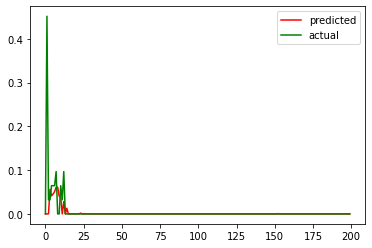

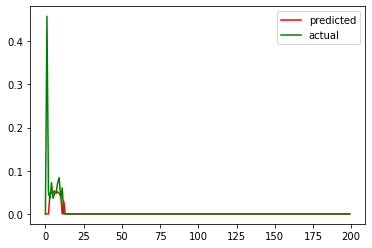

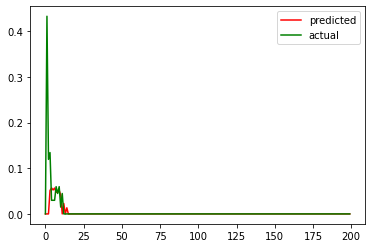

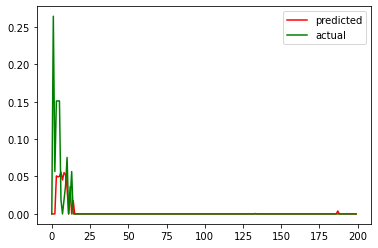

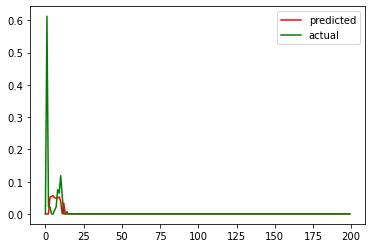

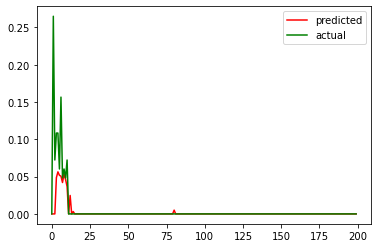

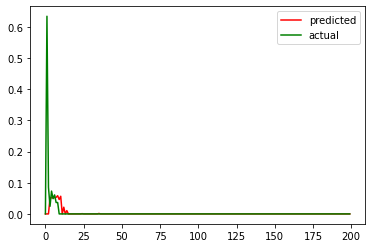

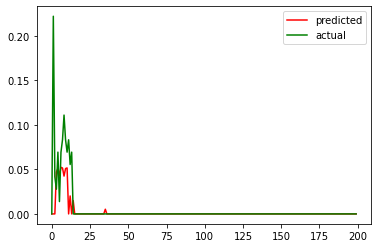

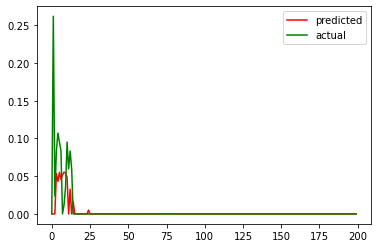

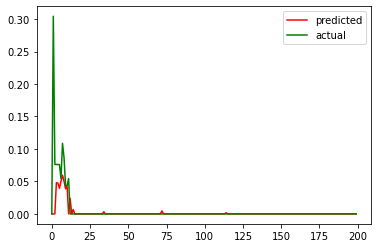

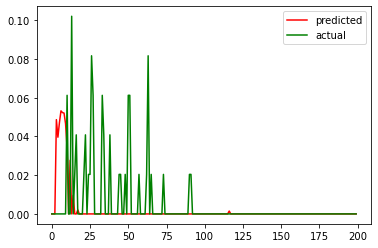

In [10]:
test_count = 0
while(test_count<=10):
    pos =  random.randint(0,1000)
    plt.plot(y_pred[pos], 'r',label = 'predicted')
    plt.plot(y_act[pos], 'g', label = 'actual')
    plt.legend()
    plt.show()
    test_count+=1